# Fairness with Interpretable Machine Learning
## **Exercise**: _Interpreting & Improving Fairness for Recidivism Risk Assessments_
### Workshop for DataScienceGO (DSGO) Virtual — scheduled for April 10th, 2020 9:45 AM PDT
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/), [Packt](https://www.packtpub.com/authors/serg-masis)) 

This notebook will walk through:

**PART I**

- Understanding fairness with confusion matrices and dataset [fairness metrics](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html)
- Training a proxy [CatBoost](https://catboost.ai/) model to attempt to understand the behavior of another model.
- Leveraging **global interpretation methods** [Feature Importance](https://catboost.ai/docs/concepts/fstr.html), [SHAP](https://shap.readthedocs.io/en/latest/examples.html#tree-explainer), and [Partial Dependence Plots](https://pdpbox.readthedocs.io/en/latest/) to understand what features impact the model and how.
- Exploring individual predictions with **local interpretation methods** [LIME](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular), [Anchors](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) and Counterfactuals with [What-If-Tool](https://pair-code.github.io/what-if-tool/).

**PART II**
- Tuning **dataset for increased interpretability and fairness** with feature engineering and balancing on protected features using [XAI](https://ethicalml.github.io/xai/index.html#balance-the-class-using-upsampling-and-or-downsampling).
- Training a XGboost **model with fairness in mind** using [monotonic constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html), [interaction constraints](https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html) and [cost-sensitive learning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html).
- Evaluating fairness of the constrained model using [XAI](https://ethicalml.github.io/xai/index.html#model-evaluation) and [AI Fairness 360](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html).

For further background on Risk Recidivisim Assessments for COMPAS dataset:

- Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias. There is software that is
used across the county to predict future criminals. And it is biased against blacks. Propublica. [Article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) | [Code Explanation](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) | [Code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

The dataset we will use has already been filtered as performed by ProPublica, and unnecessary columns removed, such as those that reveal the defendants' identities. The original dataset can be  [found here](https://www.kaggle.com/danofer/compass?select=cox-violent-parsed_filt.csv).

> ### EXCLUSIVE LIMITED-TIME OFFER
> This notebook demonstrates several of the methods in the book "Interpretable Machine Learning with Python".
> You can get it with a discount on Amazon only for a limited time:
>
> - **Edition**: Printed Edition Only (pre-order)
> - **Start Date**: 8th April 2021
> - **End Date**: 8th May 2021
> - **Discount**: 25%
> - **Code**: 25AIGLOBAL
> - **Link**: https://www.amazon.com/gp/mpc/A3H02EZHXAMXW5

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn xgboost matplotlib seaborn

Always installed unless installed already:

In [ ]:
#NOTE: It will show an error in Colab for xai 0.0.5. It will work regardless. 
# XAI doesn't really need exact versions of 6 different libraries to work.
!pip install --upgrade --quiet shap PDPbox alibi lime witwidget
!pip install --upgrade machine-learning-datasets
!pip install --no-deps git+https://github.com/EthicalML/xai.git
!pip install aif360==0.3.0

## 2) Load Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#MODELING
import xgboost as xgb
import catboost as cb

#VISUALIZATION
import machine_learning_datasets as mldatasets
import matplotlib.pyplot as plt
import seaborn as sns

#FAIRNESS
import xai
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing

#INTERPRETATION
from sklearn import metrics
import scipy
import shap
from pdpbox import pdp
import lime
from alibi.explainers import AnchorTabular
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

## 3) Data Understanding

### 3.1) Load Dataset

In [2]:
recidivism_df = mldatasets.load("recidivism-risk-10")

https://raw.githubusercontent.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/master/datasets/recidivism-risk_odsc.csv downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/dsgo/data/recidivism-risk_odsc.csv
1 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/dsgo/data folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/dsgo/data/recidivism-risk_odsc.csv


### 3.2) Verify Dataset

Should have 14,788 records and 10 columns. None of the columns have nulls, and there are three categorical (`object`) columns.

In [3]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14788 entries, 0 to 14787
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              14788 non-null  object
 1   age              14788 non-null  int64 
 2   race             14788 non-null  object
 3   juv_fel_count    14788 non-null  int64 
 4   juv_misd_count   14788 non-null  int64 
 5   juv_other_count  14788 non-null  int64 
 6   priors_count     14788 non-null  int64 
 7   c_charge_degree  14788 non-null  object
 8   compas_score     14788 non-null  int64 
 9   did_recid        14788 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 1.1+ MB


We can also gain an understanding of our data by taking a peek into first few records with `head`.

In [4]:
recidivism_df.head(10)

sex  age              race  juv_fel_count  juv_misd_count  \
0  Male   69             Other              0               0   
1  Male   69             Other              0               0   
2  Male   34  African-American              0               0   
3  Male   24  African-American              0               0   
4  Male   24  African-American              0               0   
5  Male   24  African-American              0               0   
6  Male   24  African-American              0               0   
7  Male   24  African-American              0               0   
8  Male   44             Other              0               0   
9  Male   41         Caucasian              0               0   

   juv_other_count  priors_count c_charge_degree  compas_score  did_recid  
0                0             0            (F3)             0          0  
1                0             0            (F3)             0          0  
2                0             0            (F3)             0          1  
3                1             4            (F3)             0          1  
4                1             4            (F3)             0          1  
5                1             4            (F3)             0          1  
6                1             4            (F3)             0          1  
7                1             4            (F3)             0          1  
8                0             0            (M1)             0          0  
9                0            14            (F3)             1          1

### 3.3) Examining Predictive Bias with Confusion Matrices

#### 3.3.1) Predictive Accuracy for COMPAS Model

Compare the ground truth of whether defendents did recidivate (`did_recid`) versus the prediction for medium/high risk of recidivisim (`compas_score`). 

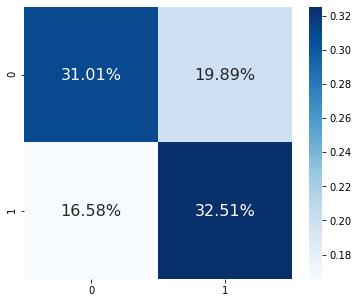

In [5]:
#Create confusion matrix.
conf_matrix = metrics.confusion_matrix(recidivism_df.did_recid,\
                                     recidivism_df.compas_score)

#Plot the confusion matrix with percetage formatting.
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

COMPAS model's predictive performance is not very good, specially if we assume that criminal justice decision-makers are taking medium or high-risk assessments at face value.It also tells false positives and negatives occur at a similar rate. Nevertheless, ***simple visualizations like the confusion matrix above obscure predictive disparities between subgroups of a population***.

#### 3.3.2) Comparing Predictive Accuracy Across Demographic Groups for COMPAS Model

We can quickly compare disparities between two subgroups that historically have been treated differently by the U.S. Criminal Justice System:

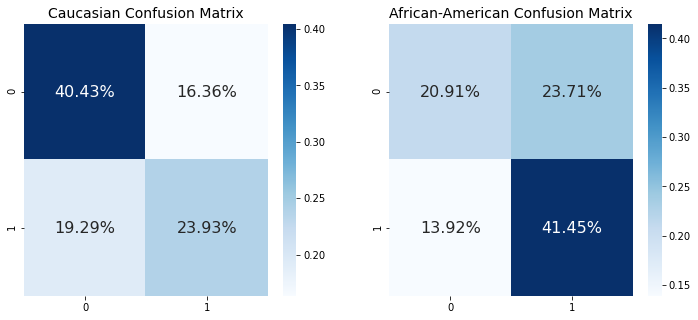

	African-American FPR:	53.1%
	Caucasian FPR:		28.8%
	Ratio FPRs:		1.84 x


In [6]:
recidivism_c_df = recidivism_df[recidivism_df.race == 'Caucasian']
recidivism_aa_df = recidivism_df[recidivism_df.race == 'African-American']

_ = mldatasets.\
      compare_confusion_matrices(recidivism_c_df.did_recid, 
                                 recidivism_c_df.compas_score,\
                                 recidivism_aa_df.did_recid,\
                                 recidivism_aa_df.compas_score,\
                                 'Caucasian', 'African-American', compare_fpr=True)

There are many disparities between both confusion matrices but ***unfairness relates more to False Positives (top right quadrant) than False Negatives (bottom left quadrant)***. 

If we wanted to convey the level of unfairness succinctly as a single metric, we could do so with _False Positive Rates_ which is the ratio between false positives over all those those that were negative (according to ground truth). African-American's are ***84% more likely to be falsely predicted to be of risk*** than Caucasians. 

> #### ----------- PART I -----------

## 4) Data Preparation

### 4.1) Encode Categorical Features

**Don't modify original dataset but make a copy**

In [7]:
recidivism2_df = recidivism_df.copy()

**Encode `sex` and `race`**

In [8]:
#One hot encode `sex` and `race` columns.
recidivism2_df = pd.get_dummies(recidivism2_df, columns=['sex', 'race'])

**How about `c_charge_degree`**

In [9]:
#List count for each category in `c_charge_degree` in descending order.
recidivism2_df.c_charge_degree.value_counts()

(F3)     8812
(M1)     3339
(F2)     1208
(M2)      991
(F1)      183
(F7)      123
(MO3)     103
(NI0)       8
(F5)        8
(CO3)       6
(F6)        5
(X)         1
(TCX)       1
Name: c_charge_degree, dtype: int64

There are many categories in `c_charge_degree` that have less than 100 defendants. The following code will bucket those categories as "Other":

In [10]:
#Leverage the `make_dummies_with_limits` function to create dummies for major c_charge_degree categores 
# (bucket smaller ones in "Other").
recidivism2_df = mldatasets.make_dummies_with_limits(recidivism2_df, 'c_charge_degree')

Categorically encodeded version of the dataset: 

In [11]:
recidivism2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14788 entries, 0 to 14787
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    14788 non-null  int64
 1   juv_fel_count          14788 non-null  int64
 2   juv_misd_count         14788 non-null  int64
 3   juv_other_count        14788 non-null  int64
 4   priors_count           14788 non-null  int64
 5   compas_score           14788 non-null  int64
 6   did_recid              14788 non-null  int64
 7   sex_Female             14788 non-null  uint8
 8   sex_Male               14788 non-null  uint8
 9   race_African-American  14788 non-null  uint8
 10  race_Asian             14788 non-null  uint8
 11  race_Caucasian         14788 non-null  uint8
 12  race_Hispanic          14788 non-null  uint8
 13  race_Native American   14788 non-null  uint8
 14  race_Other             14788 non-null  uint8
 15  c_charge_degree_(F1)   14788 non-nul

### 4.2) Train/Test Split

In [12]:
#For reproducibility, it's imperative to consistently use a seed number and set it to NumPy, 
# tensorflow or in whatever place a stochastic process exists and allows for it to be set.
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

#Create `X` and `y` and split them 80/20 corresponding for train/test.
y = recidivism2_df['compas_score']
X = recidivism2_df.drop(['compas_score', 'did_recid'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

### 4.3) Quantifying Dataset Bias (Proxy Model)

First create a AIF360 dataset with the training data:

In [13]:
train_ds = BinaryLabelDataset(df=X_train.join(y_train),\
                        label_names=['compas_score'],\
                        protected_attribute_names=['sex_Male', 'race_African-American'],
                        favorable_label=0, unfavorable_label=1)

Then, define the presumed priviledge group which are non-African-Americans, and vice-versa:

In [14]:
unprivileged_groups=[{'race_African-American': 1}]
privileged_groups=[{'race_African-American': 0}]

Now compute a few fairness metrics:

In [15]:
metrics_train_ds = BinaryLabelDatasetMetric(train_ds,\
                            unprivileged_groups=unprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.2739
Disparate Impact (DI):					0.5624
Smoothed Empirical Differential Fairness (SEDF):	0.6339


Now, let's explain what each metric means:

- **Statistical Parity Difference** (**SPD**): also know as the **Mean Difference** is the difference between the mean probability of favorable outcomes between underpriviledged and priviledged groups. A negative number is bad and a positive number is better yet a number closer to zero is always preferable. It's computed with the following formula where $f$ is the value for the favorable class.

$Pr(Y = f | D = \text{unprivileged})
           - Pr(Y = f | D = \text{privileged})$
  
- **Disparate Impact** (**DI**)): Disparate impact is exactly like _Statistical Parity Difference_ except it's the ratio not the difference. And as ratios go, the closer to one the better and under one would mean disadvantage and over one means advantage.

$\frac{Pr(Y = f | D = \text{unprivileged})}
           {Pr(Y = f | D = \text{privileged})}$
           
- **Smoothed Empirical Differential Fairness** (**SEDF**): This fairness metric is one of the many newer ones from a paper called "An Intersectional Definition of Fairness". Unlike the previous two metrics, it's not restricted to the predetermined privileges and underprivileged groups, but it's extended to include all the categories in the protected attributes, in this case, the four in _Figure 11.3_. The authors argue that fairness is particularly tricky when you have a crosstab of protected attributes. This occurs because of **Simpson's Paradox**, which is that one group can be advantaged or disadvatanged in aggregate but not when subdivided into crosstabs. We won't get into the math, but their method accounts for this possibility while measuring a sensible level of fairness in intersectional scenarios. To interpret it, zero represents absolute fairness, and the farther from zero, the less fair it is. 

## 5) Modeling

We do so as we would any model with a `fit` function and use an evaluation function to convey predictive performance.

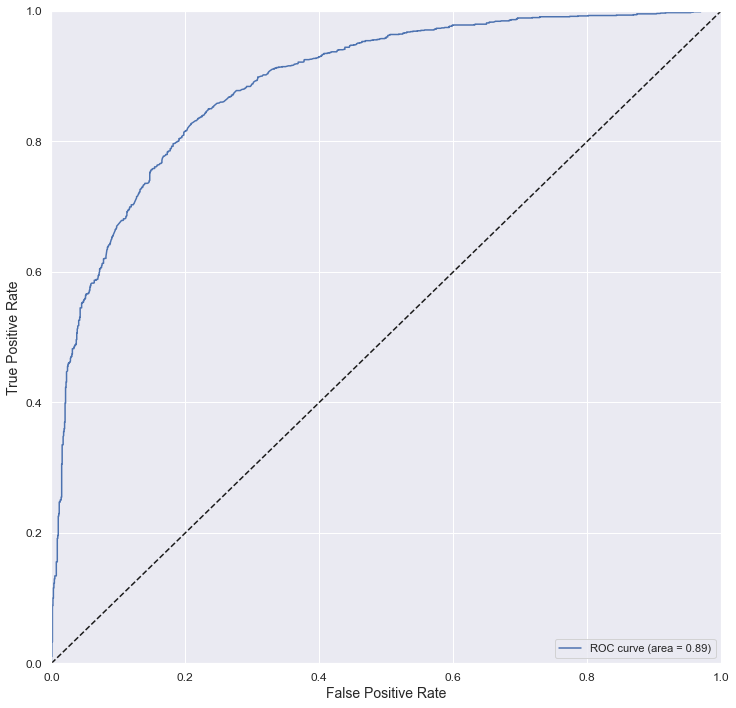

Accuracy_train:  0.8799		Accuracy_test:   0.8059
Precision_test:  0.8264		Recall_test:     0.8066
ROC-AUC_test:    0.8894		F1_test:         0.8164		MCC_test: 0.6109


In [16]:
#Initialize Model
cb_mdl = cb.CatBoostClassifier(learning_rate=0.5, depth=7, random_seed=rand)

#Train Model
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False, plot=False)

#Evaluate Model
sns.set()
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        mldatasets.evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test)

From the optics of fairness, we care more about false positives than false negatives because it's more unfair to put an "innocent" person in prison than leaving a "guilty" person in the streets. Therefore, we should aspire to have higher _precision_ than _recall_. The above metrics confirm this, as well as a healthy ROC curve, ROC-AUC and Matthews Correlation Coefficient (MCC).

## 6) Global Intepretation Methods

### 6.1) Feature Importance

Many model classes come with built-in methods for calculating "feature importance" or their intrinsic parametres (weights, coefficients, etc) are inherently interpretable. These methods are **model-specific**.

In [17]:
fitted_cb_mdl.get_feature_importance(cb.Pool(X_test, y_test), prettified=True)

Feature Id  Importances
0                     age    32.403990
1            priors_count    27.636575
2   race_African-American     4.836167
3              sex_Female     4.218100
4          race_Caucasian     4.102874
5    c_charge_degree_(F3)     3.975243
6    c_charge_degree_(M1)     3.866230
7         juv_other_count     3.315161
8          juv_misd_count     2.706353
9    c_charge_degree_(F2)     2.533637
10          race_Hispanic     1.949439
11   c_charge_degree_(M2)     1.940308
12          juv_fel_count     1.915341
13             race_Other     1.817508
14               sex_Male     1.393999
15  c_charge_degree_(MO3)     0.466222
16   c_charge_degree_(F1)     0.441368
17   c_charge_degree_(F7)     0.236432
18             race_Asian     0.115739
19  c_charge_degree_Other     0.071761
20   race_Native American     0.057553

### 6.2) SHAP (SHapley Additive exPlanations) — Model-Agnostic Method

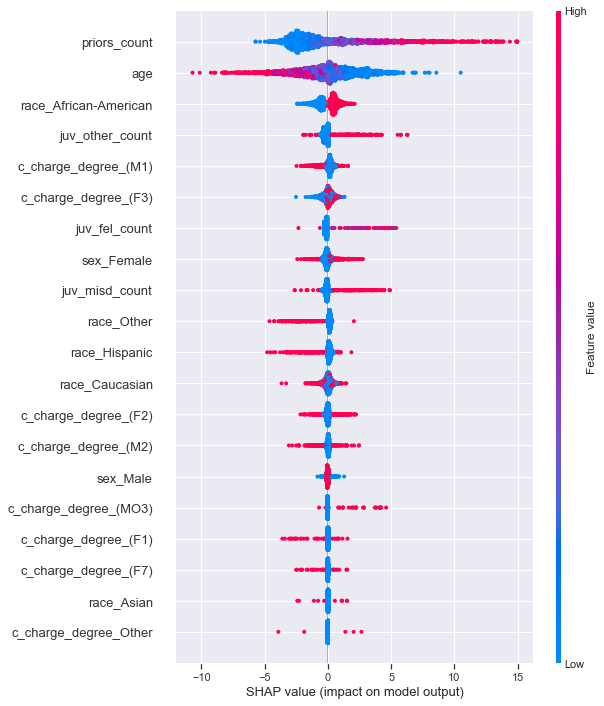

In [18]:
shap_vals = fitted_cb_mdl.get_feature_importance(cb.Pool(X_test, y_test),\
                                                   type="ShapValues")[:,:-1]

#BTW: You can use SHAP as below to generate the SHAP Values but Catboost does it for you (as above):
#  shap_explainer = shap.TreeExplainer(fitted_cb_mdl)
#  shap_vals = shap_explainer.shap_values(X_test)
#BTW: If you prefer probabilities to be returned, this is how it's done but its more time consuming:
#  shap_explainer = shap.TreeExplainer(fitted_cb_mdl, feature_dependence="independent",\
#                                      model_output="probability", data=shap.kmeans(X_train, 10).data)
#  shap_vals = shap_explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(8,12)
plt.show()

### 6.3) PDP (Partial Dependence Plots) — Model-Agnostic Method

With **PDPBox**, let's produce PDPs for the top 4 most important features, according to SHAP. To that end, let's save their names (`feature_names`) and corresponding labels (`feature_labels`) in lists.

In [19]:
feature_names = ['priors_count', 'age', 'race_African-American', 'c_charge_degree_(F3)']
feature_labels = ['# Priors', 'Age', 'race: African American', 'charge degree: Felony 3rd Level']

Then, we iterate through the lists producing PDPs for each one.

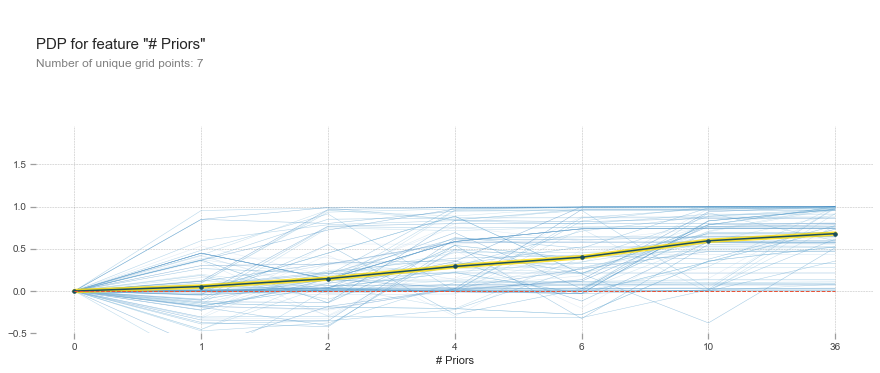

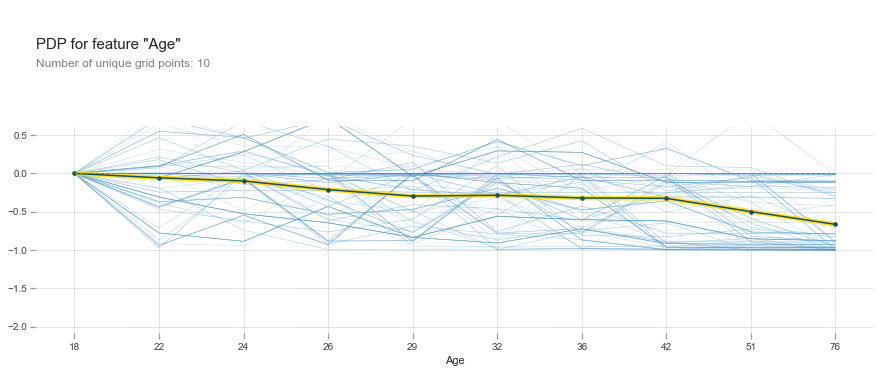

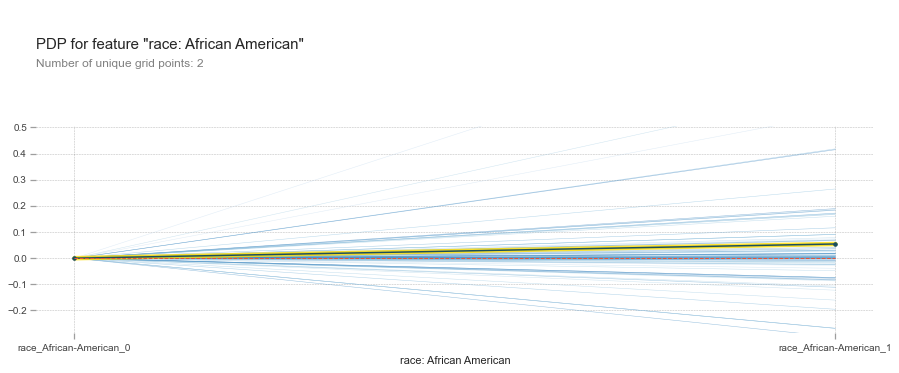

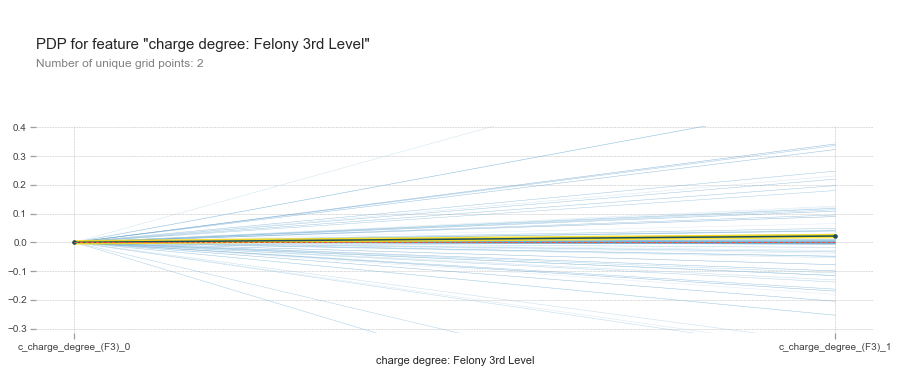

In [20]:
for i in range(len(feature_names)):
    #`pdp_isolate` computes PDP data to be plotted by `pdp_plot`.
    pdp_feat_df = pdp.pdp_isolate(\
        model=fitted_cb_mdl, dataset=pd.concat((X_test, y_test), axis=1),\
        model_features=X_test.columns, feature=feature_names[i]
    )
    #`pdp_plot` plots the partial dependence plot.
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True, x_quantile=True,\
        plot_lines=True, frac_to_plot=100, figsize=(15,6),\
        feature_name=feature_labels[i]
    )

### 6.4) Measuring Interactions

#### 6.4.1) Feature Importance for Interactions

In [21]:
#Create a dictionary that match index and column names.
col_idx_to_name = dict(zip(list(range(0, X_test.shape[1])),X_test.columns))

#Get feature importance for interaction of features and use dictionary to replace indexes with names.
#Output just the top 10 interactions.
fitted_cb_mdl.get_feature_importance(cb.Pool(X_test, y_test), type='Interaction', prettified=True).\
            replace(col_idx_to_name).\
            rename(columns={'First Feature Index':'Feature 1', 'Second Feature Index':'Feature 2'}).head(10)

Feature 1              Feature 2  Interaction
0           age           priors_count    26.008133
1           age             sex_Female     3.716289
2           age  race_African-American     3.345017
3           age         race_Caucasian     3.012341
4           age        juv_other_count     2.962314
5           age   c_charge_degree_(M2)     2.740774
6           age   c_charge_degree_(F3)     2.603601
7  priors_count  race_African-American     2.529215
8           age   c_charge_degree_(M1)     2.475654
9  priors_count             sex_Female     2.451202

#### 6.4.2) Visualizing Interactions — Model-Agnostic Methods

**SHAP can produce dependence plots that use Shap Values with "Interaction Index"**

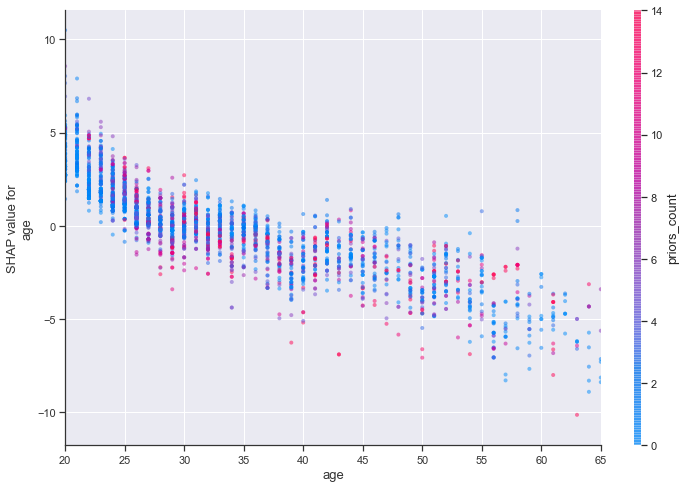

In [22]:
#Plot for `age` with interaction index for `priors_count` with `dependence_plot`. 
#We are using xmin and xmax to hide outliers and alpha of 50% to easily identify sparser areas.
shap.dependence_plot("age", shap_vals, X_test, interaction_index="priors_count",\
                     show=False, xmin="percentile(1)", xmax="percentile(99)", alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

**PDPBox can often produce interaction plots that are easier to understand**

Same as before except we iterate to xompare the most important feature with the following three most important. This time it uses different functions that take two features at a time.

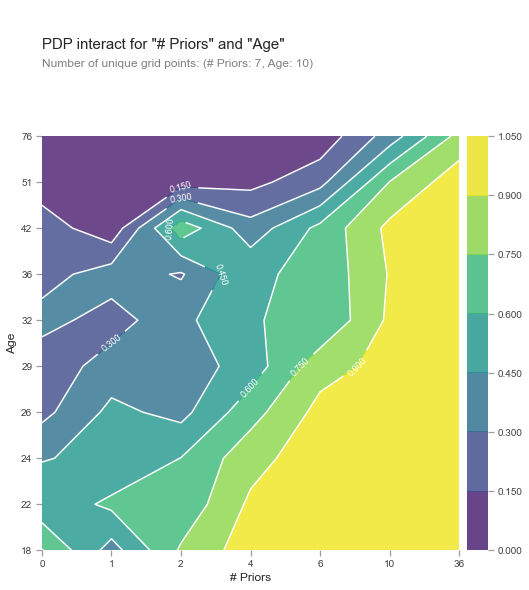

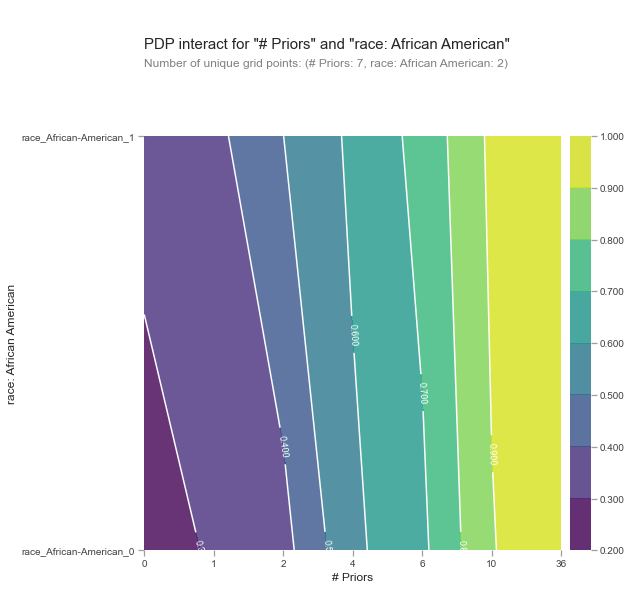

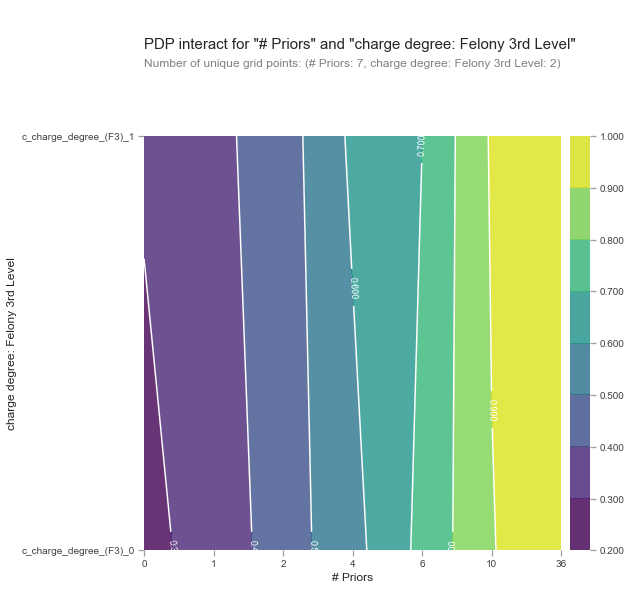

In [23]:
for i in range(1, len(feature_names)):
    try:
        #pdp_interact computes interactive PDP data to be plotted by pdp_interact_plot
        pdp_feats_df = pdp.pdp_interact(
            model=fitted_cb_mdl, dataset=pd.concat((X_test, y_test), axis=1), n_jobs=-1,\
            model_features=X_test.columns, features=[feature_names[0], feature_names[i]]
        )
        #pdp_plot plots the interactive partial dependence plot
        fig, axes = pdp.pdp_interact_plot(
            pdp_interact_out=pdp_feats_df, x_quantile=True, plot_type='contour',\
            figsize=(8,10), feature_names=[feature_labels[0], feature_labels[i]]
        )
    except:
        pass

## 7) Local Intepretation Methods

### 7.1) Examining our "Instance of Interest"

Let's assume we are asked to look into the case of an African-American male defendent with 2 priors and no juvenile offenses, his data point is our _instance of interest_. To compare, let's also take similar points, except one is Hispanic and another one is Caucasian.

In [24]:
similarity = (X_test.priors_count==2) & (X_test.juv_fel_count==0) & (X_test.juv_misd_count==0) &\
             (X_test.juv_other_count==0) & (X_test['sex_Male']==1)

#The index of an African-American Defendent (the instance of interest).
aa_idx = X_test[(X_test.age==23) & similarity & (X_test['race_African-American']==1) &\
                (X_test['c_charge_degree_(F7)']==1)].index[0]

#The index of two similar datapoints for and Hispanic and Caucasian defendents.
h_idx = X_test[(X_test.age==23) & similarity & (X_test['race_Hispanic']==1) &\
               (X_test['c_charge_degree_(F3)']==1)].index[0]
c_idx = X_test[(X_test.age==24) & similarity & (X_test['race_Caucasian']==1) &\
               (X_test['c_charge_degree_(M1)']==1)].index[0]

#Create boolean array to easily locate indexes in X_test dataframe.
instance_idxs = X_test.index.isin([aa_idx, h_idx, c_idx])

#Find instances in both X_test and recidivism2_df dataframes.
X_test_instances = X_test[instance_idxs]
X_instances = recidivism2_df[recidivism2_df.index.isin([aa_idx, h_idx, c_idx])]

#Create a dataframe joining y_test (the `compas_score` label), y_test_cb_pred (the predictions for Catboost),
# X_instances (to get `did_recid`) and X_test (for the rest of the features).
compare_df = pd.concat([\
            pd.DataFrame({'compas_score':y_test[instance_idxs]},\
                         index=[c_idx, h_idx, aa_idx]),\
            pd.DataFrame({'y_pred':y_test_cb_pred[instance_idxs]},\
                         index=[c_idx, h_idx, aa_idx]),\
            pd.DataFrame({'did_recid':np.array(X_instances['did_recid'])},\
                         index=[c_idx, h_idx, aa_idx]),\
            X_test_instances], axis=1).set_index([pd.Index(['Caucasian',\
                            'Hispanic', 'African-American'])]).transpose().\
            style.apply(lambda x: ['background: yellow' if (x[2] != x[1] or x[2] != x[0])\
            else '' for i in x], axis=1).apply(lambda x: ['background: lightgreen'\
            if (x.name == 'did_recid') else '' for i in x], axis=1)

compare_df

### 7.2) LIME — Model-Agnostic Method

**Initialize LIME Explainer for Tabular Data**

In [25]:
#Providing the names of the classes make for more readable explanations.
class_names = ['Low Risk', 'Medium/High Risk']

#Instatiate Lime Tabular explainer with the test data, class names, feature names and 
# indexes of categorical features.
lime_cb_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, class_names=class_names,\
                        feature_names=X_test.columns, categorical_features=np.where(X.dtypes != np.int64)[0])

**Explain Instance for African-American Defendant**

In [26]:
#All LIME requires to explain an instance, is the data for the instance, the predict function and 
# how many features to limit the explanation to.
lime_cb_explainer.explain_instance(X_test.loc[aa_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

**Explain Instance for Caucasian Defendant**

In [27]:
lime_cb_explainer.explain_instance(X_test.loc[c_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

**Explain Instance for Hispanic Defendant**

In [28]:
lime_cb_explainer.explain_instance(X_test.loc[h_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

### 7.3) Anchors Explanations — Model-Agnostic Method

**Initialize Anchor Explainer for Tabular Data**

In [29]:
#These are all the categorical features, and what their categories are called.
#Anchor uses this to make a human interpretable explanation.
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

#All Anchor needs from the model is a predict function. 
#In this case, we use `predict_proba` and wrap it in a lambda function.
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)

#Instantiating AnchorTabular only requires predict function, names of columns,
#and (optionally) category map. 
anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)

#Then you fit the explainer it to the training data
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)}}
)

**Explain Instance for African-American Defendant**

In [30]:
#Provide the explainer an instance and a threshold, and it will generate
# an explanation.
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[aa_idx].values, threshold=0.85,\
                                seed=rand)

#Print the explanation:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[aa_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Medium/High Risk
Anchors: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American
Precision: 0.892
Coverage: 0.290


Now, same as before but let's increase the threshold:

In [31]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[aa_idx].values, threshold=0.95,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[aa_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Could not find an result satisfying the 0.95 precision constraint. Now returning the best non-eligible result.


Prediction: Medium/High Risk
Anchors: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	c_charge_degree_(F1) = Not Felony 1st Level AND
	sex_Male = Male AND
	race_Hispanic = Not Hispanic AND
	race_Caucasian = Not Caucasian AND
	c_charge_degree_Other = Not Other Charge Degree AND
	c_charge_degree_(F3) = Not Felony 3rd Level AND
	race_Other = Not Other Race AND
	sex_Female = Not Female AND
	race_Asian = Not Asian AND
	c_charge_degree_(M2) = Not Misdemeanor 2nd Deg AND
	juv_misd_count <= 0.00 AND
	race_Native American = Not Native American AND
	c_charge_degree_(MO3) = Not Misdemeanor 3rd Deg AND
	c_charge_degree_(F7) = Felony 7th Level AND
	c_charge_degree_(F2) = Not Felony 2nd Level AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	juv_fel_count <= 0.00 AND
	juv_other_count <= 0.00
Precision: 0.946
Coverage: 0.290


**Explain Instance for Caucasian Defendant**

In [32]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[c_idx].values, threshold=0.85,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[c_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Low Risk
Anchors: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	c_charge_degree_(M1) = Misdemeanor 1st Deg
Precision: 0.867
Coverage: 0.578


**Explain Instance for Hispanic Defendant**

In [33]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[h_idx].values, threshold=0.85,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[h_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Low Risk
Anchors: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	sex_Male = Male AND
	juv_other_count <= 0.00 AND
	c_charge_degree_(F2) = Not Felony 2nd Level AND
	juv_misd_count <= 0.00 AND
	juv_fel_count <= 0.00 AND
	c_charge_degree_(M2) = Not Misdemeanor 2nd Deg
Precision: 0.851
Coverage: 0.957


### 7.4) Counterfactual Explanations with WIT (What-If-Tool) — Model-Agnostic Method

The following two function will help generate the dashboard configuration:

In [34]:
def custom_predict_with_shap(inputs_l, train_cols_idx, predict_fn, shap_vals, train_cols_l):
    """Return predictions and attributions dictionary for WIT dashboard.
    
    Keyword arguments:
    inputs_l -- input data (list)
    train_cols_idx -- index of columns used in training of model (list or array)
    predict_fn -- the prediction function for the model (function)
    shap_vals -- SHAP values for models features and observations (array)
    keepcols_l -- column names used in training of model (list or array)
    """
    
    #For predictions we need observations with same features
    # that were used for training.
    inputs_np = np.array(inputs_l)[:,train_cols_idx]

    #Get the model's class predictions.
    preds = predict_fn(inputs_np)

    if shap_vals is not False:
        #With test data generate SHAP values which converted
        # to a list of dictionaries format.
        attributions = []
        for shap in shap_vals:
            attrs = {}
            for i, col in enumerate(train_cols_l):
                attrs[col] = shap[i]
            attributions.append(attrs)

        #Prediction function must output 
        # predictions/attributions in dictionary.
        output = {'predictions': preds,\
                  'attributions': attributions}
    else:
        output = {'predictions': preds}
        
    return output

def create_wit_config_for_model(fitted_mdl, wit_df, train_cols_l, target, class_names, shap_vals=None):
    """Generate a WIT Configuration for model.
    
    Keyword arguments:
    fitted_mdl -- a fitted tree-based model (catboost, xgboost, lightgbm, scikit-learn)
    wit_df -- data you want to load in dashboard (pandas dataframe)
    keep_cols_l -- column names used in training of model (list or array)
    target -- the name of the column which is the target feature
    class_names -- the name of the classes (list or array)
    shap_vals -- SHAP values for models features and observations (array)
    """
    
    #The indexes of the columns used to train the model.
    train_cols_idx = np.where(wit_df.columns.isin(train_cols_l))[0]
    
    #WIT needs a predict function for the model.
    predict_fn = lambda x: fitted_mdl.predict_proba(x)
    
    #If not provided, generate SHAP values.
    if shap_vals is None:
        shap_explainer = shap.TreeExplainer(fitted_mdl)
        shap_vals = shap_explainer.shap_values(wit_df)

    #Used by the WIT Config Builder to call the custom predict function.
    custom_predict_with_shap_fn = lambda inputs_l: custom_predict_with_shap(inputs_l, train_cols_idx,\
                                                                            predict_fn, shap_vals,\
                                                                            train_cols_l)
    
    #WIT config needs the data as a list but first we convert to a NumPy array. 
    wit_np = wit_df.values

    #WIT config needs the names of all the columns.
    cols_l = wit_df.columns
    
    #Create the config with all the previously prepared elements.
    wit_config_builder = WitConfigBuilder(\
                        wit_np.tolist(), feature_names=cols_l.tolist()
                    ).set_custom_predict_fn(custom_predict_with_shap_fn).\
                    set_target_feature(target).set_label_vocab(class_names)

    return wit_config_builder

We will need the location of the index for our main instance of interest so we can locate it in the dashboard:

In [35]:
print(y_test.index.get_loc(aa_idx))

1566


Now, let's build the dashboard.

In [36]:
#All the dashboard widget requires is the configuration. Optionally, you can set a height (in pixels).  
WitWidget(create_wit_config_for_model(fitted_cb_mdl, recidivism2_df.loc[y_test.index],\
                                      X_train.columns.to_list(), "did_recid", class_names,\
                                      shap_vals), height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Low Risk', 'Medium/High Risk'], 'feature_na…

**Ideas on what can be done with WIT**

- When datapoints are organized by "inference score" you can select any point in the area where red and blue classes meet, called the boundary line. With this point selected, you look for it's nearest counterfactual and examine what is different between both points or look at it's partial dependence plot to see how decision changes as value changes for each feature.
- You can scatter also based on SHAP attributions. For instance between `attributions__age` and `attributions__priors_count` while color coded for `inference_score` to see how they relate.
- With the "Performance and Fairness" tab, slice the dataset by `race_African-American` to see how model performance varies per slice and how you can slide the positive classification thresholds to get fairer results.

> #### ----------- PART II -----------

## 8) Tuning for Interpretability

### 8.1) Feature Engineering for Interpretability

#### 8.1.1) Charge Degree: from categorical to ordinal

In [37]:
#First, let's make a copy of the dataframe to start over data preparation.
recidivism3_df = recidivism_df.copy()
#What categories did `c_charge_degree` originally have?
recidivism3_df.c_charge_degree.value_counts()

(F3)     8812
(M1)     3339
(F2)     1208
(M2)      991
(F1)      183
(F7)      123
(MO3)     103
(NI0)       8
(F5)        8
(CO3)       6
(F6)        5
(X)         1
(TCX)       1
Name: c_charge_degree, dtype: int64

Some are more severe than others. Let's give this column an order. **Might not make an impact performance wise but it will be more interpretable**.

In [38]:
charge_degree_code_rank = {'(F10)': 15, '(F9)':14, '(F8)':13, '(F7)':12, '(TCX)':11, '(F6)':10, '(F5)':9,\
                           '(F4)':8, '(F3)':7, '(F2)':6, '(F1)':5, '(M1)':4, '(NI0)':4, '(M2)':3,\
                           '(CO3)':2, '(MO3)':1, '(X)':0}
recidivism3_df.c_charge_degree.replace(charge_degree_code_rank, inplace=True)

#### 8.1.2) Age: from numeric to categorical (age groups)

In [39]:
recidivism3_df['age_groups'] = pd.qcut(recidivism3_df.age, 7, precision=0).astype(str)
recidivism3_df.groupby(['age_groups'])['compas_score'].sum()/recidivism3_df['age_groups'].value_counts()

(17.0, 22.0]    0.721082
(22.0, 25.0]    0.643785
(25.0, 29.0]    0.588506
(29.0, 32.0]    0.554663
(32.0, 38.0]    0.478853
(38.0, 48.0]    0.380590
(48.0, 96.0]    0.277477
dtype: float64

The first two age groups correspond to what research says are **when most criminal activity and recidivism occurs**. 

#### 8.1.3) Priors Count: to interaction term

In [40]:
recidivism3_df['priors_per_year'] = recidivism3_df['priors_count']/(recidivism3_df['age'] - 17)

Observe how probability of recidivism increases with priors count:

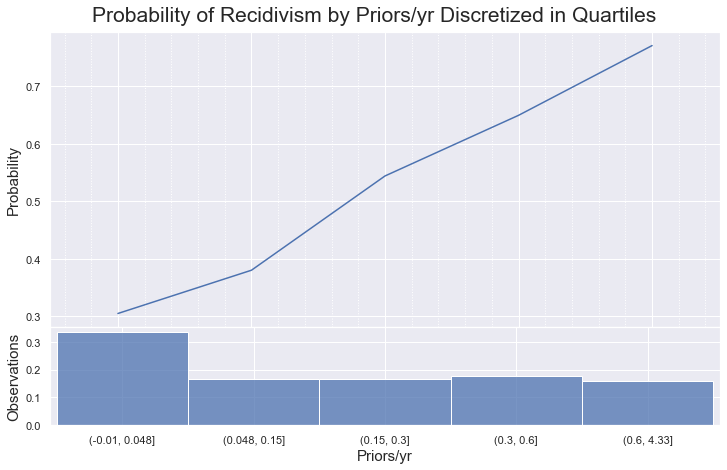

In [41]:
mldatasets.plot_prob_progression(recidivism3_df.priors_per_year, recidivism3_df.did_recid,\
                                 x_intervals=6, use_quartiles=True, xlabel='Priors/yr',\
                title='Probability of Recidivism by Priors/yr Discretized in Quartiles')

**Recidivism rate tends to increase as priors per years increases** which is the justification for this new feature.

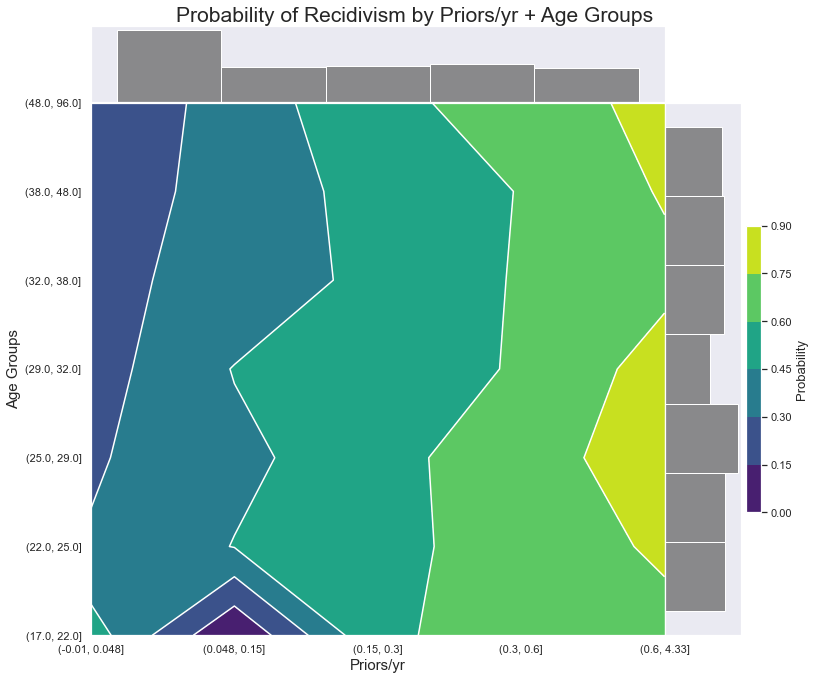

In [42]:
mldatasets.plot_prob_contour_map(recidivism3_df.priors_per_year, recidivism3_df.age_groups, recidivism3_df.did_recid,\
                                 x_intervals=6, use_quartiles=True, xlabel='Priors/yr', ylabel='Age Groups',\
                 title='Probability of Recidivism by Priors/yr + Age Groups')

#### 8.1.4) Remove unecessary features

In [43]:
recidivism3_df.drop(['age', 'priors_count'], axis=1, inplace=True)

It is better to have broader age groups than individual ages because the model will get too detailed guided by gaps in the training data. Priors count is not needed anymore if the interaction term better represents the impact of priors in recidivism.

### 8.2) Mitigating Bias with XAI

#### 8.2.1) Measuring Imbalances

The imbalance of `race` is the one we most care about.

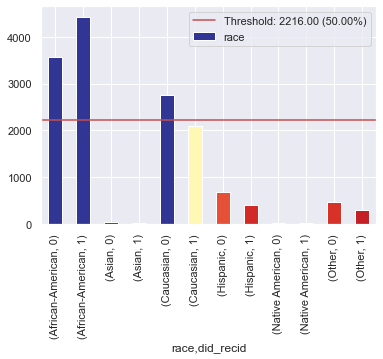

In [44]:
sns.set()
categorical_cols_l = ["race", "sex", "age_groups", "compas_score", "did_recid"]

xai.imbalance_plot(recidivism3_df, "race", "did_recid",\
                   categorical_cols=categorical_cols_l)

Besides `African-American` and `Caucasian`, all other races are entirely below the red line (in orange). 

#### 8.2.1) Adjusting for Imbalances

**Put lesser represented races in "Other" category**

The races that in previous chart were in orange can be bucketed as "Other" since it will be harder to balance the dataset by `race` accounting for them individually, and they don't really exhibit imbalance anyway.

In [45]:
recidivism3_df['race'] = np.where((recidivism3_df.race=='African-American') |\
                                  (recidivism3_df.race=='Caucasian'), recidivism3_df.race, 'Other')

**Plot imbalance again**

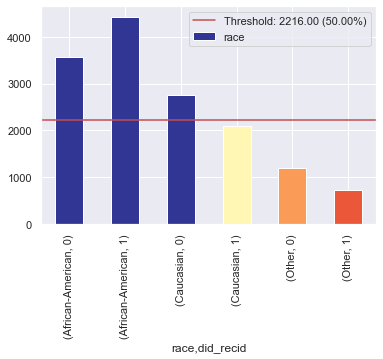

In [46]:
xai.imbalance_plot(recidivism3_df, "race", "did_recid",\
                   categorical_cols=categorical_cols_l)

All the blue bars should be downsampled to reach the red line, and all the rest are to be upsampled.

**Balance by `race`**

We could make all bars the same size by upsampling up to a higher amount. However, the "Other" `race` is not one third of the dataset and we wouldn't want the model to learn from so much upsampled data. Therefore, it's best to limit it to `0.27` which is where `(Other, 0)` and `(Other, 1)` match.

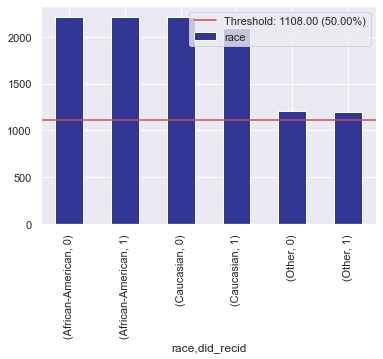

In [47]:
recidivism3_bal_df = xai.balance(recidivism3_df, "race", "did_recid",\
                                 categorical_cols=categorical_cols_l,\
               downsample=0.5, upsample=0.27)

**Check for `sex` imbalance**

This is often a consideration because you expect females and males to be evenly distributed in datasets. When broken down further by target variable you would also expect an even - and therefore fair - distribution. However, **women are far less likely to commit crimes and recidivate**. We will keep this imbalance noting that we could be much more rigurous here by making sure our data reflected the real-life recidivism rates.

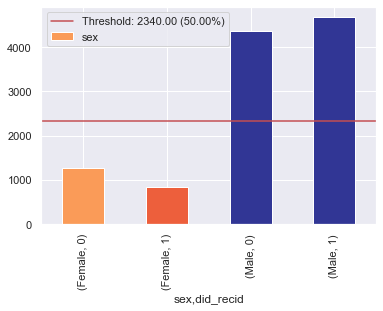

In [48]:
xai.imbalance_plot(recidivism3_bal_df, "sex", "did_recid",\
                   categorical_cols=categorical_cols_l)

### 8.3) Categorical Encode

In [49]:
#Encode categorical columns.
categorical_cols_bal_l = ['sex', 'race', 'age_groups']
recidivism3_proc_df = xai.convert_categories(recidivism3_bal_df,\
                                            categorical_cols=categorical_cols_bal_l)

### 8.4) Train/Test Split Balanced Dataset

In [50]:
#Split into Train/Test (note that `balanced_train_test_split` is being used for good measure).
y_bal = recidivism3_proc_df['did_recid']
X_bal = recidivism3_proc_df.drop(['compas_score', 'did_recid'], axis=1).copy()
X_train_bal, y_train_bal, X_test_bal, y_test_bal, train_bal_idx, test_bal_idx =\
                        xai.balanced_train_test_split(X_bal, y_bal, "race",\
                                            categorical_cols=categorical_cols_bal_l,\
                                            min_per_group=444)

#Create dataframes with the balanced train and test data but prior to categorical encoding.
X_train_display = recidivism3_bal_df[train_bal_idx]
X_test_display = recidivism3_bal_df[test_bal_idx]

#Create dataframes with entire data including labels.
train_df = X_train_bal.copy()
train_df["did_recid"] = y_train_bal
test_df = X_test_bal.copy()
test_df["did_recid"] = y_test_bal
test_display_df = X_test_display.copy()
test_display_df["did_recid"] = y_test_bal

### 8.5) Quantifying Dataset Bias (Base Model)

First create a AIF360 dataset with the training data:

In [51]:
train_bal_ds = BinaryLabelDataset(df=train_df,\
                        label_names=['did_recid'],\
                        protected_attribute_names=['sex', 'race'],
                        favorable_label=0, unfavorable_label=1)

test_bal_ds = BinaryLabelDataset(df=test_df,\
                        label_names=['did_recid'],\
                        protected_attribute_names=['sex', 'race'],
                        favorable_label=0, unfavorable_label=1)

Then, define the presumed priviledge group which are non-African-Americans, and vice-versa:

In [52]:
unprivileged_groups=[{'race': 0}]
privileged_groups=[{'race': 1}]

Now compute a few fairness metrics:

In [53]:
metrics_train_ds = BinaryLabelDatasetMetric(train_bal_ds,\
                            unprivileged_groups=unprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.0177
Disparate Impact (DI):					0.9659
Smoothed Empirical Differential Fairness (SEDF):	0.4866


### 8.6) Train Base Model

[09:12:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


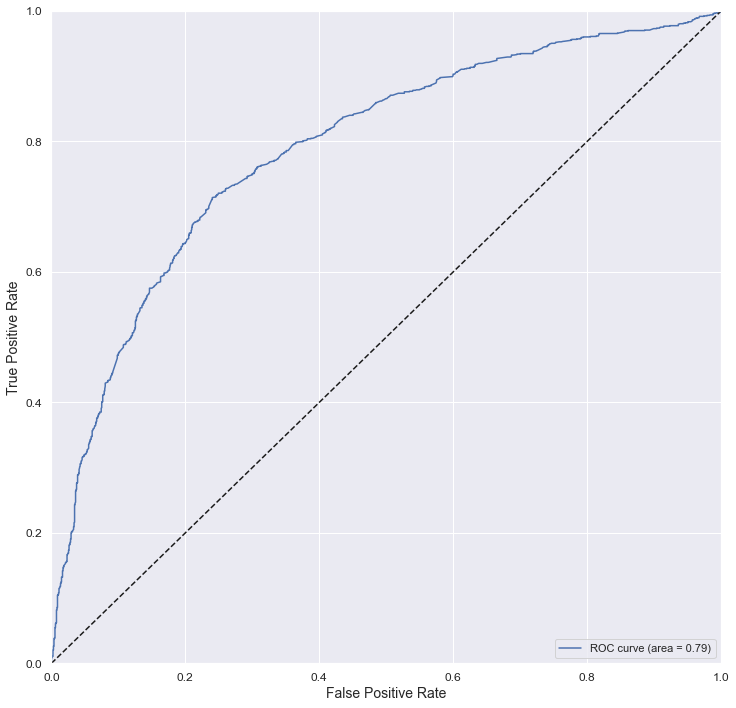

Accuracy_train:  0.8355		Accuracy_test:   0.7320
Precision_test:  0.7500		Recall_test:     0.6959
ROC-AUC_test:    0.7890		F1_test:         0.7220		MCC_test: 0.4652


In [54]:
xgb_base_mdl = xgb.XGBClassifier(seed=rand, eta=1, max_depth=7,\
                                reg_lambda=1.5, reg_alpha=0.75)
xgb_base_mdl = xgb_base_mdl.fit(X_train_bal, y_train_bal)
y_train_xgb_pred, y_test_xgb_prob, y_test_xgb_pred =\
        mldatasets.evaluate_class_mdl(xgb_base_mdl, X_train_bal, X_test_bal,\
                                                 y_train_bal, y_test_bal)

### 8.7) Quantifying Model Bias (Base Model)

In [55]:
test_pred_ds = test_bal_ds.copy(deepcopy=True)
test_pred_ds.labels = y_test_xgb_pred.reshape(-1,1)
test_pred_ds.scores = y_test_xgb_prob.reshape(-1,1)
_, metrics_test_cls =\
        mldatasets.compute_aif_metrics(test_bal_ds, test_pred_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_test_cls.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_test_cls.disparate_impact())
print('Average Odds Difference (AOD):\t\t\t\t%.4f' %\
      metrics_test_cls.average_odds_difference())
print('Equal Opportunity Difference (EOD):\t\t\t%.4f' %\
      metrics_test_cls.equal_opportunity_difference())
print('Differential Fairness Bias Amplification (DFBA):\t%.4f' %\
      metrics_test_cls.differential_fairness_bias_amplification())

Statistical Parity Difference (SPD):			-0.0259
Disparate Impact (DI):					0.9548
Average Odds Difference (AOD):				-0.0259
Equal Opportunity Difference (EOD):			-0.0586
Differential Fairness Bias Amplification (DFBA):	0.1895


Now, putting the metrics we already explained aside, let's explain what the other ones mean:

- **Average Odds Difference** (**AOD**): The difference between false-positive rates (`FPR`) averaged with the difference between false-negative rates (`FNR`) for both privileged and underprivileged groups. Negative means there's a disadvantage for the underprivileged group, and the closer to zero, the better.

$\tfrac{1}{2} \left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
           + (TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}))\right]$
           
- **Equal Opportunity Difference** (**EOD**):  It's only the TPR differences of AOD, so it's only useful to measure the "opportunity" for true-positive rates. Like AOD, negative confirms a disadvantage for the underprivileged group, and the closer to zero, the better.

$TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}$ 

- **Differential Fairness Bias Amplification**: This metric comes from the same paper as SEDF, and like it also has zero as baseline of fairness. However, it only measures the difference in unfairness in proportion between the model and the data in a phenomenon it called bias amplification. In other words, the value represents how much more the model increases unfairness over the original data. 

### 8.8) Training a Constrained and Cost-Sensitive Model

#### 8.8.1) Deciding on Monotonic Constraints

Compute Spearman's rank correlation coefficient between each feature and the target (`did_recid`). When positive correlation is greater than 0.5, **assign a monotonic constraint of 1**. When correlation is negative and below -0.5, **assign a monotonic constraint of -1**. Otherwise 0.

In [56]:
#Output dataframe with features and the spearman correlation value for `did_recid`.
pd.DataFrame({'feature': X_bal.columns,\
              'correlation_to_target': np.delete(scipy.stats.spearmanr(recidivism3_bal_df.drop(['did_recid'], axis=1)).correlation[6],6)\
             }).style.background_gradient(cmap='plasma')

Only `only_priors_per_year` can be monotonic. It's not quite above `0.5` but almost there.

In [57]:
mono_con = (0, 0, 0, 0, 0, 0, 0, 1)

#### 8.8.2) Deciding on Interactive Constraints

First, inititalize SHAP's tree explainer but instead of deriving SHAP values used SHAP interaction values:

In [58]:
shap_xgb_base_explainer = shap.TreeExplainer(xgb_base_mdl)
shap_xgb_base_interact_values = shap_xgb_base_explainer.shap_interaction_values(X_test_bal)

The following code extracts the absolute mean interaction values per feature pair and puts them in a heatmap. Then, zeroes the diagonals in the heatmap (because these aren't interaction values) and then plots the heatmap with the labels.

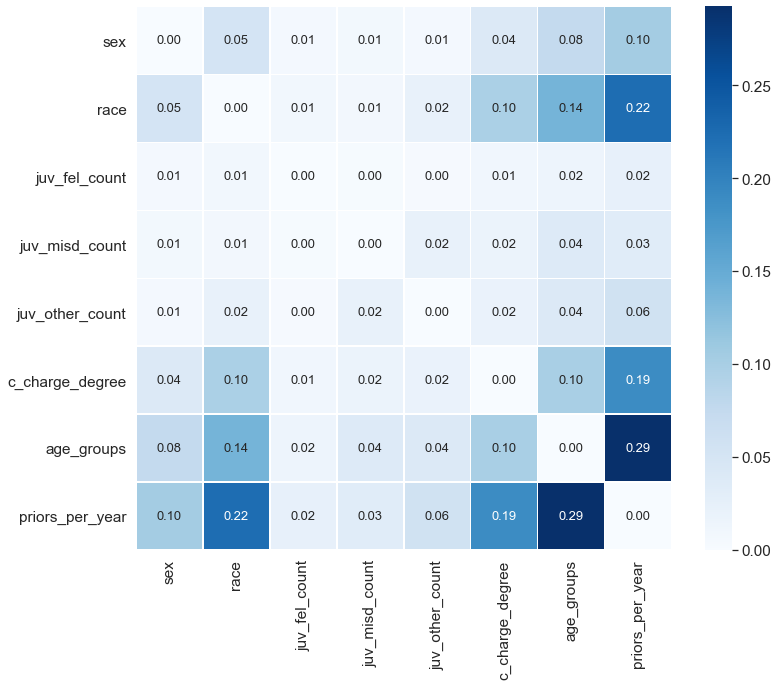

In [59]:
shap_xgb_base_interact_avgs = np.abs(shap_xgb_base_interact_values).mean(0)
np.fill_diagonal(shap_xgb_base_interact_avgs, 0)
shap_xgb_base_interact_df = pd.DataFrame(shap_xgb_base_interact_avgs)
shap_xgb_base_interact_df.columns = X_test_bal.columns
shap_xgb_base_interact_df.index = X_test_bal.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_xgb_base_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':13}, fmt='.2f', linewidths=.5)
plt.show()

We decide to put `race` on it's own and group the last three together, and the rest together as well:

In [60]:
interact_con = [[1],[0, 2, 3, 4],[5, 6, 7]]

#### 8.8.3) Deciding on Weight for Cost-Sensitive Learning

Negative and positive classes are already fairly balanced. If they weren't you'd use something close to the number below.

In [61]:
print(y_train_bal[y_train_bal==0].shape[0]/y_train_bal[y_train_bal==1].shape[0])

1.0306586826347306


However, since we'd like to penalize False Positives, we can take a number smaller than `1.03`. Let's use `0.96`.

In [62]:
scale_pos_weight = 0.96

We also have hyperparameter tuned parameters we will plug-in:

In [63]:
best_xgb_params = {'eta': 1.2, 'max_depth': 9, 'reg_alpha': 0.39,\
                   'reg_lambda': 1, 'scale_pos_weight': scale_pos_weight}

#### 8.8.4) Training Constrained Model on Balanced Dataset

[09:12:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


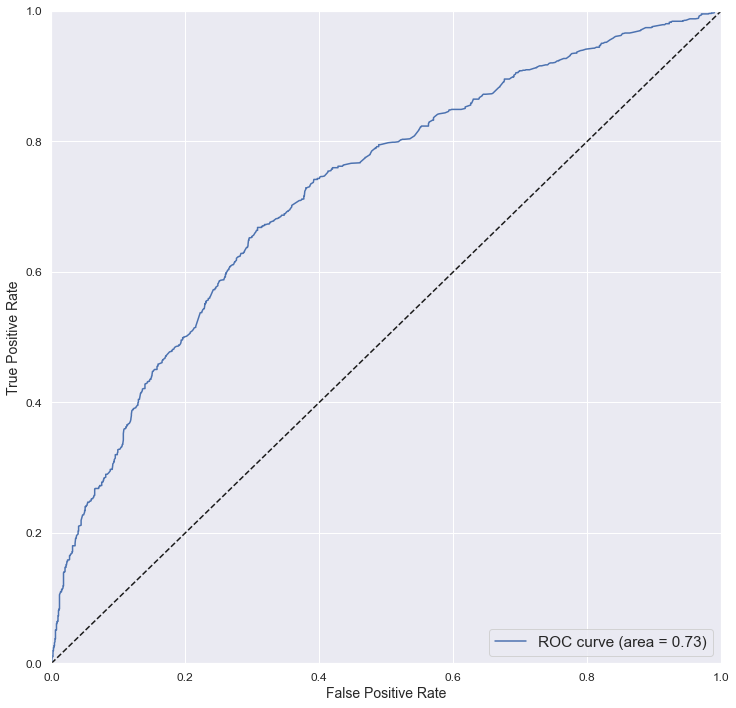

Accuracy_train:  0.6849		Accuracy_test:   0.6776
Precision_test:  0.6870		Recall_test:     0.6524
ROC-AUC_test:    0.7251		F1_test:         0.6692		MCC_test: 0.3556


In [64]:
xgb_con_mdl = xgb.XGBClassifier(seed=rand,\
                            monotone_constraints=mono_con,\
                            interaction_constraints=interact_con,\
                            **best_xgb_params)
xgb_con_mdl = xgb_con_mdl.fit(X_train_bal, y_train_bal)
y_train_xgb_con_pred, y_test_xgb_con_prob, y_test_xgb_con_pred =\
        mldatasets.evaluate_class_mdl(xgb_con_mdl, X_train_bal, X_test_bal,\
                                                 y_train_bal, y_test_bal)

Predictive performance is not as good as previous model, but remember that this model is not a proxy model anymore but trained as ground truth (`did_recid`) as the target. When compared to COMPAS, accuracy actually was better. In any case, we are more interested in fairness.

### 8.9) Assessing Fairness for Constrained Model

#### 8.9.1) Comparing Confusion Matrices

We use the same code we used _3.3.2)_ but adapted for the constrained models results.

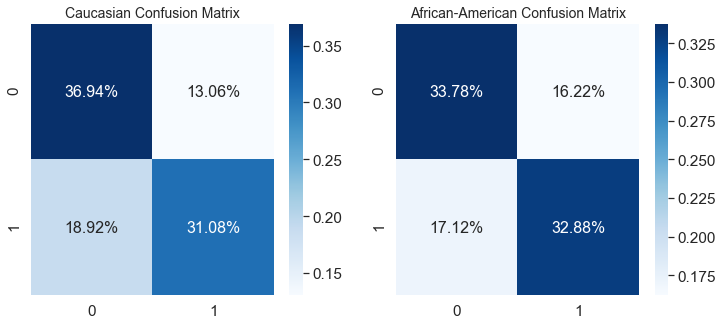

	African-American FPR:	32.4%
	Caucasian FPR:		26.1%
	Ratio FPRs:		1.24 x


In [65]:
_ = mldatasets.\
            compare_confusion_matrices(y_test_bal[X_test_bal.race==1], y_test_xgb_con_pred[X_test_bal.race==1],\
                                       y_test_bal[X_test_bal.race==0], y_test_xgb_con_pred[X_test_bal.race==0],\
                                       'Caucasian', 'African-American', compare_fpr=True)

#### 8.9.2) Quantifying Model Bias (Constrained Model)

We use the same code we used _8.7)_ but adapted for the constrained models results.

In [66]:
test_pred_con_ds = test_bal_ds.copy(deepcopy=True)
test_pred_con_ds.labels = y_test_xgb_con_pred.reshape(-1,1)
test_pred_con_ds.scores = y_test_xgb_con_prob.reshape(-1,1)
_, metrics_test_cls =\
        mldatasets.compute_aif_metrics(test_bal_ds, test_pred_con_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_test_cls.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_test_cls.disparate_impact())
print('Average Odds Difference (AOD):\t\t\t\t%.4f' %\
      metrics_test_cls.average_odds_difference())
print('Equal Opportunity Difference (EOD):\t\t\t%.4f' %\
      metrics_test_cls.equal_opportunity_difference())

Statistical Parity Difference (SPD):			-0.0495
Disparate Impact (DI):					0.9113
Average Odds Difference (AOD):				-0.0495
Equal Opportunity Difference (EOD):			-0.0631


#### 8.9.3) Reviewing Interaction Constraints

We use the same code we used _8.8.1)_ but adapted for the constrained models results.

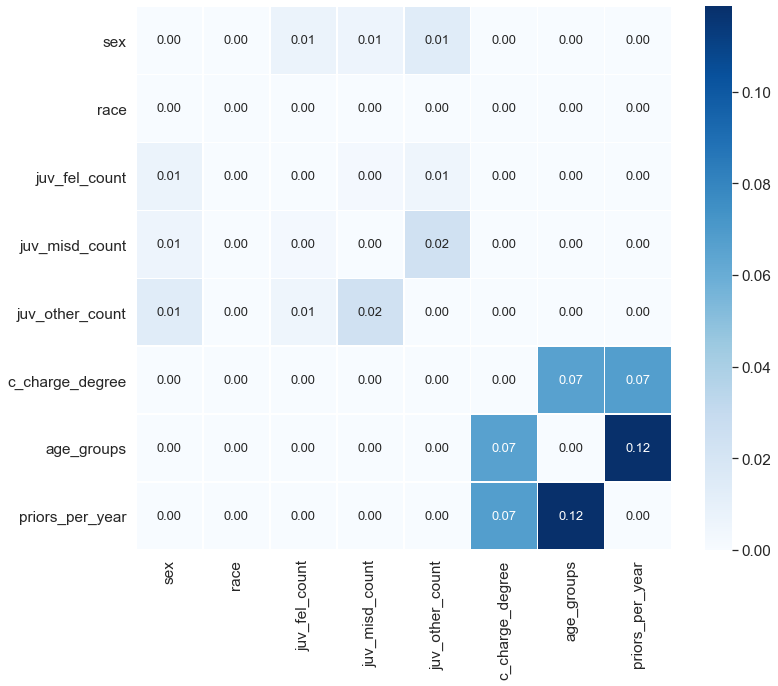

In [67]:
shap_xgb_con_explainer = shap.TreeExplainer(xgb_con_mdl)
shap_xgb_con_interact_values = shap_xgb_con_explainer.shap_interaction_values(X_test_bal)
shap_xgb_con_interact_avgs = np.abs(shap_xgb_con_interact_values).mean(0)
np.fill_diagonal(shap_xgb_con_interact_avgs, 0)
shap_xgb_con_interact_df = pd.DataFrame(shap_xgb_con_interact_avgs)
shap_xgb_con_interact_df.columns = X_test_bal.columns
shap_xgb_con_interact_df.index = X_test_bal.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_xgb_con_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':13}, fmt='.2f', linewidths=.5)
plt.show()

#### 8.9.4) Equalized Odds Postprocessing

Initialize, fit and predict:

In [68]:
epp = EqOddsPostprocessing(privileged_groups=privileged_groups,\
                           unprivileged_groups=unprivileged_groups,\
                           seed=rand)
epp = epp.fit(test_bal_ds, test_pred_con_ds)
test_pred_epp_ds = epp.predict(test_pred_ds)

Compute fairness metrics:

In [69]:
_, metrics_test_cls =\
        mldatasets.compute_aif_metrics(test_bal_ds, test_pred_epp_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_test_cls.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_test_cls.disparate_impact())
print('Average Odds Difference (AOD):\t\t\t\t%.4f' %\
      metrics_test_cls.average_odds_difference())
print('Equal Opportunity Difference (EOD):\t\t\t%.4f' %\
      metrics_test_cls.equal_opportunity_difference())

Statistical Parity Difference (SPD):			0.0236
Disparate Impact (DI):					1.0449
Average Odds Difference (AOD):				0.0236
Equal Opportunity Difference (EOD):			0.0045


Derive labels and scores from fitted Equalized Post-Processing dataset:

In [70]:
y_test_epp_pred = test_pred_epp_ds.labels[:,0]
y_test_epp_prob = test_pred_epp_ds.scores[:,0]

Verify results by visualizing confusion matrices:

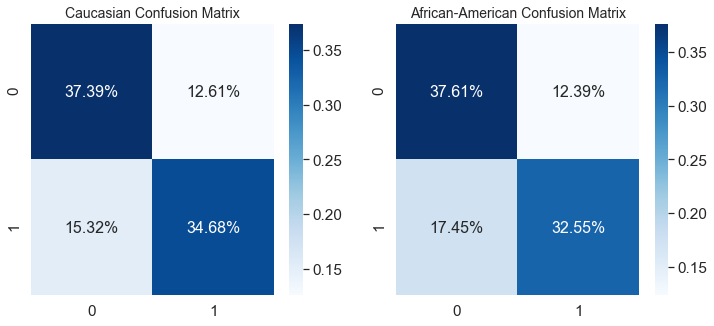

	Caucasian FPR:	25.2%
	African-American FPR:		24.8%
	Ratio FPRs:		1.02 x


In [71]:
_ = mldatasets.\
            compare_confusion_matrices(y_test_bal[X_test_bal.race==1], y_test_epp_pred[X_test_bal.race==1],\
                                       y_test_bal[X_test_bal.race==0], y_test_epp_pred[X_test_bal.race==0],\
                                       'Caucasian', 'African-American', compare_fpr=True)

#### 8.9.5) Evaluating Fairness of Monotonic Model with XAI

**For Predictive Performance Metrics**

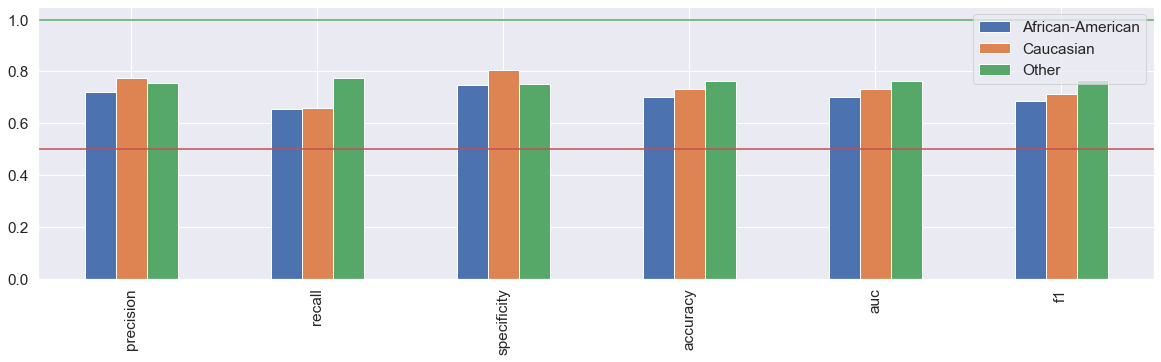

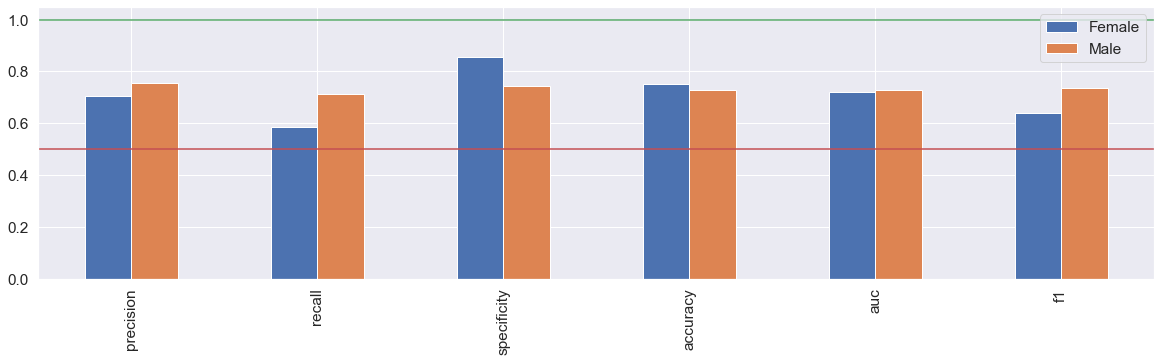

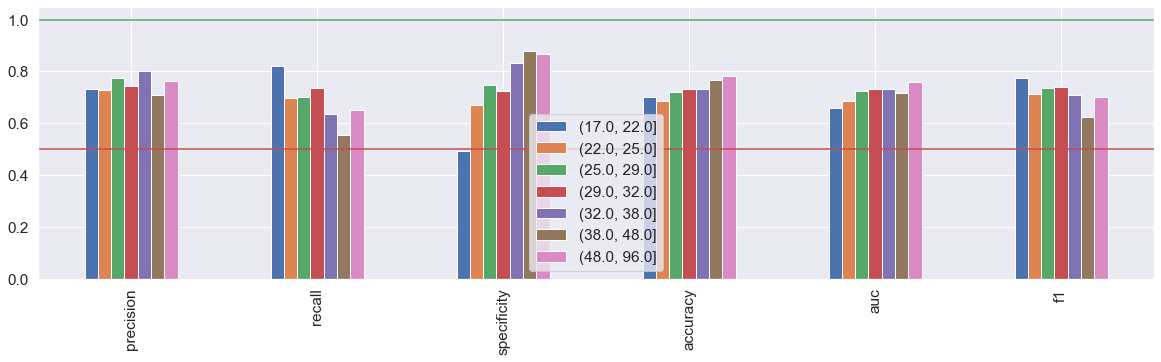

In [72]:
protected_cols_l = ["race", "sex", "age_groups"]
for p in protected_cols_l:
    _ = xai.metrics_plot(
        y_test_bal, 
        y_test_epp_prob, 
        df=test_display_df, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

**For ROC Curves**

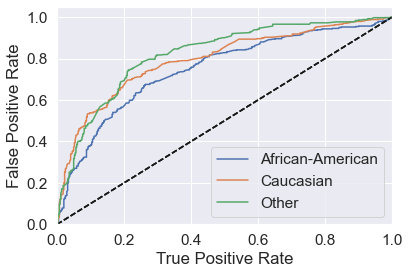

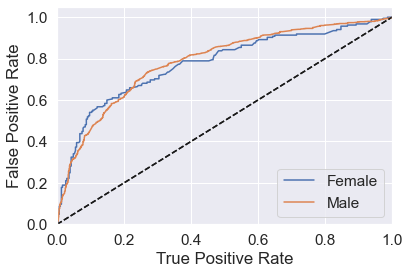

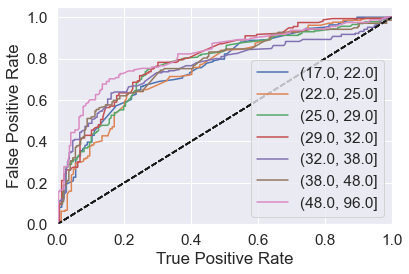

In [73]:
for p in protected_cols_l:
    _ = xai.roc_plot(
        y_test_bal, 
        y_test_epp_prob, 
        df=test_display_df,  
        cross_cols=[p],
        categorical_cols=protected_cols_l)

**For Precision-Recall Curve**

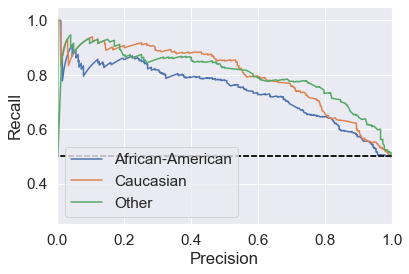

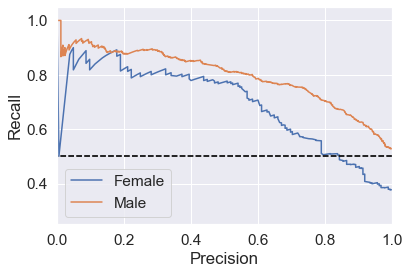

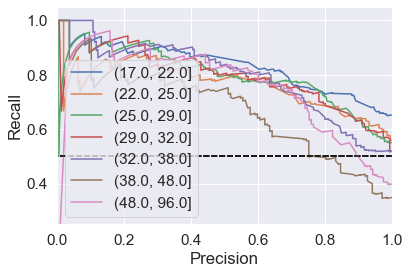

In [74]:
for p in protected_cols_l:
    _ = xai.pr_plot(
        y_test_bal, 
        y_test_epp_prob, 
        df=test_display_df, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)